#**Accented English Speech Experiments**

The present project presents two main experiments: the evaluation of two speech-to-text models from OpenAI, Whisper Medium English-Only and Whisper Medium Multilingual, as well as the task of accent recognition with the Support Vector Machine implementation from Scikit-learn.

The project uses *The Speech Accent Archive* from George Mason University, housing accented English samples by speakers from around the world. The database can be found at https://accent.gmu.edu/index.php. The Whisper models from OpenAI can be found and downloaded from the following page https://huggingface.co/openai/whisper-large-v3. Finally, the documentation for the Support Vector Machines from Scikit-learn is retrievable at https://scikit-learn.org/stable/modules/svm.html.

##**Part 1: Evaluation of Whisper's English-Only and Multilingual Speech-to-Text Models on Accented English**

The first part of the project focuses on the evaluation of the two medium-sized speech-to-text models from OpenAI, namely the Whisper English-Only and the Whisper Multilingual models. The evaluation underwent three stages. In stage one, text similarity was calculated using the Levenshtein distance, testing both with and without the inclusion of native speaker accents. The difference between models and between native speaker inclusion were tested for statistical significance. In the second stage, the individual accents were evaluated for their performance in the Whisper model. Finally, the third stage repeated an abridged subsection of the first stage using instead the Word Error Rate (WER) to calculate text similarity.

###**Set Up**

In [ ]:
#Setting Up Folder Usage
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Speech Technologies/Final Project

In [ ]:
#Necessary Packages - Part 1
! pip install python-Levenshtein
import Levenshtein
!pip install jiwer
import jiwer
from jiwer import wer
import requests
from bs4 import BeautifulSoup
import re as regex
import glob
import librosa
from tqdm import tqdm
import time
import csv
import pickle
import numpy as np
import matplotlib.pyplot as plt
import ast

###**Scraping Audio Samples from Corpus**

This section downloads all speaker audio files from *The Speech Accent Archive* for later use in model evaluation. The corpus houses a total of 3030 audio samples.

**Following Cells:**

1.   Scrapes the archive website to get access to the links for each individual language.
2.   Scrapes the archive website to get access to the links for each individual speaker.
3.   Uses the links for each individual speaker to scrape the url for each speaker's audio of the text.
4.   Scapes and locally downloads all audio files.

In [ ]:
#Creating a Link Dictionary for Each Language in the Corpus (for Access to Speakers)
url = 'https://accent.gmu.edu/browse_language.php'

r = requests.get(url)
source = r.text
soup = BeautifulSoup(source)

re = regex.compile(r'[\s]')
corpus_dict = {}

for element in soup.find_all('a')[9:]:
  try:
    lang = element.get_text()
    link = element['href']

    if ' ' in lang:
      space_fixer = re.sub('%20', lang)
      corpus_dict[lang] = 'https://accent.gmu.edu/browse_language.php?function=find&language=' + space_fixer

    else:
      corpus_dict[lang] = 'https://accent.gmu.edu/' + link

  except:
    print(element.get_text(), 'is not available.')

corpus_dict

In [ ]:
#Creating a Dictionary Housing Links to Individual Speakers with Speaker Codes as Keys
speaker_dict = {}
re = regex.compile(r'[,]')

for link in corpus_dict.values():
  r = requests.get(link)
  source = r.text
  soup = BeautifulSoup(source)

  try:
    if 'this language' in soup.find('div', class_ = 'content').get_text():
      pass

    else:
      for element in soup.find_all('a'):
        if 'speaker' in element['href']:
          lang = element.get_text()
          lang_clean = re.sub('', lang)
          link = element['href']

          speaker_dict[lang_clean] = 'https://accent.gmu.edu/' + link

  except AttributeError:
    pass

print('There are a total of %d audio samples in the corpus.'%len(speaker_dict))
speaker_dict

In [ ]:
#Finding the Total Number of Samples for the Top Ten Language Accents by Sample Count
samps = []
for samp in speaker_dict.keys():
  samps.append(samp)

newsamps = []
for samp in samps:
  lang = regex.findall('[a-z]+', samp)
  num = regex.findall('[1-9]+', samp)
  newsamps.append((lang[0], int(num[0])))

langs = ['spanish', 'arabic', 'mandarin', 'korean', 'french', 'russian', 'portuguese', 'dutch', 'german', 'turkish']

newlangs = []
for samp in newsamps:
  if samp[0] in langs:
    newlangs.append(samp)

sorted(newlangs, key = lambda x : x[1], reverse = True)

len(newlangs)

1081

In [ ]:
#Creating a Dictionary with Links to the MP3s of Each Speaker with Speaker Codes as Keys (DONT RERUN - 20 Minute Runtime)
mp3_links = {}
for lang, link in speaker_dict.items():
  r = requests.get(link)
  source = r.text
  soup = BeautifulSoup(source)

  mp3_links[lang] = 'https://accent.gmu.edu' + soup.find('source')['src']

print('There are a total of %d MP3s in the corpus.'%len(mp3_links))
mp3_links

In [ ]:
#Downloading All Audio Files to Drive (DONT RERUN)
for lang, link in mp3_links.items():
  audio = requests.get(link)

  with open (f'Audios/{lang}.mp3', 'wb') as f:
    f.write(audio.content)

###**Loading and Evaluating the Models**

This stage loads the medium-size English-Only and Multilingual Whisper models from OpenAI into Colab to prepare for their evaluation.

English-Only Whisper: https://huggingface.co/openai/whisper-medium.en.

Multilingual Whisper: https://huggingface.co/openai/whisper-medium.

Text similarity was calculated through the Levenshtein Distance, derived from the minimum number of single-character edits needed to change one text into the other. Each transcription was compared to a standard control text (i.e. the prompt given to elicit the audio samples). This distance score was then normalized by the length of the control text to create a similarity percentage of the two texts. The Levenshtein distance was originally chosen to have a measure of greater accuracy (down to the character level) in comparing the Whisper produced transcriptions to the control text. After carrying out the analysis, it has come to my attention that a better measure of performance would be the Word Error Rate (WER), as this is the industry standard in evaluating speech-to-text models. Due to time constraints and the laborious nature of running the Whisper model, only a selection of samples were evaluated for their WER, which can be found in the section entitled **Additional Evaluations** below.   

The evaluation was carried out in two stages: one taking into consideration audio files of native English speakers and one having removed such audios to test performance solely on non-native accents. Evaluation was carried out on a smaller subsection of the database - 606 samples representing 1/5 of the dataset - for time purposes.

The results of first stage (with native English speakers) is as follows:

*   English-Only Model Accuracy: **95.61%**.
*   Multilingual Model Accuracy: **95.92%**.

The model trained on multilingual data, i.e. data from other languages alongside English data, was .31% more accurate than the model trained exclusively on English data. The difference is unsurprisingly not statistically significant (z-value of .98 < 1.96 threshold (95% confidence) in z-test; Cohen's d of 0.037). The English-Only model evaluation was, however, quite a bit faster than that of the Multilingual model, clocking in at 7.5 hours of computation for 606 samples, whereas the Multilingual model took 10.46 hours to process the same set of samples. For the English-Only model, that is about 44.5 seconds per sample, whereas for the Multilingual model, that is around 62.1 seconds per sample.    

Native English speakers were then removed from the data due to concerns that their inclusion may be inflating the true accuracy rate of the models' speech-to-text transcriptions. In order to hold constant the size of the evaluation test sets (606 samples - 1/5 of the dataset), a new test set of audios was randomly selected, excluding native English speakers. The results of the second stage (without native English speakers) is as follows:

*   English-Only Model Accuracy: **95.13%**.
*   Multilingual Model Accuracy: **95.45%**.

Unexpectedly, the models had nearly the same accuracy percentage, despite removing the potential inflation from native speakers. The Multilingual model outperformed the English-Only model again, this time with an additional .32% accuracy. The difference is still not statistically significant (z-value of 1.06 < 1.96 threshold (95% confidence) in z-test; Cohen's d of 0.04). Here, the models performed with nearly the same amount of time, with English-Only taking 10.45 hours and the Multilingual 10.94 hours to process 606 samples. For the English-Only model, that is about 62.1 seconds per sample, whereas the Multilingual model performed with around 65 seconds per sample. I attribute the speed of the first English-Only model evaluation (with native English speakers) to greater runtime resource allocation from Google Colab, which would bring the processing time down to around 30-40 seconds per audio sample. Without the boost, the average processing time appears to lie around 60-65 seconds.

I then tested the statistical significance between the evaluations of the English-Only models and that of the Multilingual models to see whether the inclusion of native English speakers actually had a notable effect on the accuracy of the models. The difference was not statistically significant for neither the English-Only model evaluations (z-value of 1.3 < 1.96 threshold (95% confidence) in z-test; Cohen's d of 0.055) nor the Multilingual model evaluations (z-value of 1.51 < 1.96 threshold (95% confidence) in z-test; Cohen's d of 0.064).

**Following Subsections**

1. Preparation
2. English-Only Model Evaluation
3. Multilingual Model Evaluation
4. Statistical Analysis


###**1. Preparation**

**Following Cells:**

1.   Creates and locally saves a standard batch of 606 samples for evaluation by both models.
2.   Creates and locally saves a standard batch of 606 samples without native English speakers for evaluation by both models.
3.   Instantiates empty dictionaries for the English-only model evaulation.
4.   Instantiates empty dictionaries for the Multilingual model evaluation.

In [ ]:
#Creating a Batched List of Files and Pickling it (DO NOT RERUN)
audio_list = [audio for audio in glob.glob('/content/gdrive/MyDrive/Speech Technologies/Final Project/Audios/*.mp3')]
np.random.shuffle(audio_list)

slices = [101] * 30
slices[0] += 3030 % 30
audio_bins = [[audio_list.pop(0) for _ in audio_list[:s]] for s in slices]

#Pickling so as to always use the same instance of the variable in processing the audio data
with open("audio_bins.txt", 'wb') as fout:
    pickle.dump((audio_bins), fout)

In [ ]:
#Creating a Batched List of Files (WITHOUT NATIVE ENGLISH SPEAKERS) and Pickling it (DO NOT RERUN)
audio_list = [audio for audio in glob.glob('/content/gdrive/MyDrive/Speech Technologies/Final Project/Audios/*.mp3') if 'english' not in audio]
np.random.shuffle(audio_list)

slices = [101] * 30
slices[0] += 3030 % 30
audio_bins_ne = [[audio_list.pop(0) for _ in audio_list[:s]] for s in slices]

#Pickling so as to always use the same instance of the variable in processing the audio data
with open("audio_bins_ne.txt", 'wb') as fout:
    pickle.dump((audio_bins_ne), fout)

In [ ]:
#First Instantiation of the English-Only Scores Dictionary (DO NOT RERUN)
scores_dict_en = {}

scores_dict_en_ne = {} #without native English speakers

In [ ]:
#First Instantiation of the English-Only Scores Dictionary (DO NOT RERUN)
scores_dict_ml = {}

scores_dict_ml_ne = {} #without native English speakers

###**2. English-Only**

**Following Cells:**

1.   Loads in the English-Only Model from HuggingFace.
2.   Reloads previous progress for working between runtimes.
3.   Reloads previous progress for working between runtimes for the evaulation without native English speakers.
4.   Evaluates the English-Only Model. Comprised of:

> *  The control text.
> *  Definition for cleaning the transcription output of the model.
> *  Definition for evaluating the Levenshtein text similarity scores for the transcription text to the control text.
> *  Code for loading and transcribing audios, activating the cleaning and evaluation definitions, and writing the evaluations to an external document.



In [ ]:
#Code to Load the English-Only Model
import torch
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from transformers import pipeline

#Loading the model and processor
processor_en = WhisperProcessor.from_pretrained("openai/whisper-medium.en")
model_en = WhisperForConditionalGeneration.from_pretrained("openai/whisper-medium.en")

#Loading a torch pipeline to batch long audio samples (>30 seconds)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

pipe = pipeline(
    'automatic-speech-recognition',
    model = 'openai/whisper-medium.en',
    chunk_length_s = 30,
    device = device
)

In [ ]:
#Code for Reloading Previous Progress

#Reinstantiating the scores dictionary
scores_dict_en = {}

with open('model_en_scores.csv') as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    scores_dict_en[row[0]] = row[1]

#Loading audio bins
with open("audio_bins.txt", 'rb') as fin:
    audio_bins = pickle.load(fin)

In [ ]:
#Code for Reloading Previous Progress (WITHOUT NATIVE ENGLISH SPEAKERS)

#Reinstantiating the scores dictionary
scores_dict_en_ne = {}

with open('model_en_scores_ne.csv') as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    scores_dict_en_ne[row[0]] = row[1]

#Loading audio bins
with open("audio_bins_ne.txt", 'rb') as fin:
    audio_bins_ne = pickle.load(fin)

In [ ]:
"""ENGLISH MODEL EVALUATION"""

start = time.time()

#Creating a local variable for the control text to which the transcriptions will be compared
text_in = 'Please call Stella. Ask her to bring these things with her from the store: Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob. We also need a small plastic snake and a big toy frog for the kids. She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'
re = regex.compile(r'[,.:\'\[\]*]')
text = re.sub('', text_in.lower())


#Defining a function which cleans the transcriptions for comparison with the control text
def clean_trans(transcription):
  re = regex.compile(r'[,.:\'\[\]*]')

  nopunct = re.sub('', str(transcription).lower())
  clean = nopunct.strip()

  return clean


#Defining a function which calculates the similarity score between two texts (here, the control text and the transcription)
def sim_score(text, transcription_clean):
  distance = Levenshtein.distance(text, transcription_clean)
  max_len = len(text)

  similarity_percentage = ((max_len - distance) / max_len) * 100

  return similarity_percentage


#Speech-to-Text audio processing
for audio in tqdm(audio_bins_ne[5], unit = "Audio"): #EDIT HERE
  update = time.time()
  print(f' The current audio file being processed is {audio.split("/")[-1]}.')

  #Loading in audio
  sig, sr = librosa.load(audio, sr = 16000)

  #Transcribing audio to text
  if len(sig) >= 480000: #for audio samples longer than 30 seconds
    transcription = pipe(sig.copy(), batch_size = 8)

  else: #for all remaining samples
    input_features = processor_en(sig, sampling_rate = sr, return_tensors = "pt").input_features #reads in audio (input must be an array)

    predicted_ids = model_en.generate(input_features) #generates token ids

    transcription = processor_en.batch_decode(predicted_ids, skip_special_tokens = True) #decodes token ids to text

  #Cleaning the transcribed output
  transcription_clean = clean_trans(transcription)

  #Calculating the similarity score between the transcription and the control text
  similarity_percentage = sim_score(text, transcription_clean)

  #Updating the dictionary with the audio name and similarity score
  scores_dict_en_ne[audio.split("/")[-1]] = similarity_percentage

  #Continually saving all results to an external CSV file
  with open('model_en_scores_ne.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    for lang, score in scores_dict_en_ne.items():
      writer.writerow([lang, score, 'Batch 5']) #EDIT HERE


#Printing end metrics
end = time.time()
print(' The total runtime of the operation elapsed %g seconds.'%round(end - start))

###**3. Multilingual**

**Following Cells:**

1.   Loads in the Multilingual Model from HuggingFace.
2.   Reloads previous progress for working between runtimes.
3.   Reloads previous progress for working between runtimes for the evaulation without native English speakers.
4.   Evaluates the Multilingual Model. Comprised of:

> *  The control text.
> *  Definition for cleaning the transcription output of the model.
> *  Definition for evaluating the Levenshtein text similarity scores for the transcription text to the control text.
> *  Code for loading and transcribing audios, activating the cleaning and evaluation definitions, and writing the evaluations to an external document.

In [ ]:
#Code to Load the Multilingual Model
import torch
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from transformers import pipeline

#Loading the model and processor
processor_ml = WhisperProcessor.from_pretrained("openai/whisper-medium")
model_ml = WhisperForConditionalGeneration.from_pretrained("openai/whisper-medium")
forced_decoder_ids_ml = processor_ml.get_decoder_prompt_ids(language="english", task="transcribe") #forces the task (transcribing) and language (English)

#Loading a torch pipeline to batch long audio samples (>30 seconds)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

pipe = pipeline(
    'automatic-speech-recognition',
    model = 'openai/whisper-medium',
    generate_kwargs={"language": "english"},
    chunk_length_s = 30,
    device = device
)

In [ ]:
#Code for Reloading Previous Progress

#Reinstantiating the scores dictionary
scores_dict_ml = {}

with open('model_ml_scores.csv') as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    scores_dict_ml[row[0]] = row[1]

#Loading audio bins
with open("audio_bins.txt", 'rb') as fin:
    audio_bins = pickle.load(fin)

In [ ]:
#Code for Reloading Previous Progress (WITHOUT NATIVE ENGLISH SPEAKERS)

#Reinstantiating the scores dictionary
scores_dict_ml_ne = {}

with open('model_ml_scores_ne.csv') as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    scores_dict_ml_ne[row[0]] = row[1]

#Loading audio bins
with open("audio_bins_ne.txt", 'rb') as fin:
    audio_bins_ne = pickle.load(fin)

In [ ]:
"""MULTILINGUAL MODEL EVALUATION"""

start = time.time()


#Creating a local variable for the control text to which the transcriptions will be compared
text_in = 'Please call Stella. Ask her to bring these things with her from the store: Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob. We also need a small plastic snake and a big toy frog for the kids. She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'
re = regex.compile(r'[,.:\'\[\]*]')
text = re.sub('', text_in.lower())


#Defining a function which cleans the transcriptions for comparison with the control text
def clean_trans(transcription):
  re = regex.compile(r'[,.:\'\[\]*]')

  nopunct = re.sub('', str(transcription).lower())
  clean = nopunct.strip()

  return clean


#Defining a function which calculates the similarity score between two texts (here, the control text and the transcription)
def sim_score(text, transcription_clean):
  distance = Levenshtein.distance(text, transcription_clean)
  max_len = len(text)

  similarity_percentage = ((max_len - distance) / max_len) * 100

  return similarity_percentage


#Speech-to-Text audio processing
for audio in tqdm(audio_bins_ne[5], unit = "Audio"): #EDIT HERE
  update = time.time()
  print(f' The current audio file being processed is {audio.split("/")[-1]}.')

  #Loading in audio
  sig, sr = librosa.load(audio, sr = 16000)

  #Transcribing audio to text
  if len(sig) >= 480000: #for audio samples longer than 30 seconds
    transcription = pipe(sig.copy(), batch_size = 8)

  else: #for all remaining samples
    input_features = processor_ml(sig, sampling_rate = sr, return_tensors = "pt").input_features #reads in audio (input must be an array)

    predicted_ids = model_ml.generate(input_features, forced_decoder_ids = forced_decoder_ids_ml) #generates token ids

    transcription = processor_ml.batch_decode(predicted_ids, skip_special_tokens = True) #decodes token ids to text

  #Cleaning the transcribed output
  transcription_clean = clean_trans(transcription)

  #Calculating the similarity score between the transcription and the control text
  similarity_percentage = sim_score(text, transcription_clean)

  #Updating the dictionary with the audio name and similarity score
  scores_dict_ml_ne[audio.split("/")[-1]] = similarity_percentage

  #Saving all results to an external CSV file
  with open('model_ml_scores_ne.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    for lang, score in scores_dict_ml_ne.items():
      writer.writerow([lang, score, 'Batch 5']) #EDIT HERE


#Printing end metrics
end = time.time()
print(' The total runtime of the operation elapsed %g seconds.'%round(end - start))

###**4. Statistical Analysis**

**Following Cells:**

1.   Reimports the external dictionaries housing the Levenshtein Distance scores for each round of evaluation.
2.   Calculates the average accuracy of each model.
3.   Calculates the statistics on the average accuracy of each model.

In [ ]:
#Reloading the Dictionaries into Python
scores_dict_en = {} #English-Only with native English speakers
with open('Safe-Keeping/model_en_scores.csv') as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    scores_dict_en[row[0]] = row[1]

scores_dict_ml = {} #Multilingual with native English speakers
with open('Safe-Keeping/model_ml_scores.csv') as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    scores_dict_ml[row[0]] = row[1]

scores_dict_en_ne = {} #English-Only without native English speakers
with open('Safe-Keeping/model_en_scores_ne.csv') as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    scores_dict_en_ne[row[0]] = row[1]

scores_dict_ml_ne = {} #Multilingual without native English speakers
with open('Safe-Keeping/model_ml_scores_ne.csv') as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    scores_dict_ml_ne[row[0]] = row[1]

In [ ]:
#Calculating the Average Accuracy of the Various Models and Stages
en_mdl = [float(score) for score in scores_dict_en.values()]
ml_mdl = [float(score) for score in scores_dict_ml.values()]
en_mdl_ne = [float(score) for score in scores_dict_en_ne.values()]
ml_mdl_ne = [float(score) for score in scores_dict_ml_ne.values()]

print(f'The accuracy of the English-Only Model is {sum(en_mdl) / len(en_mdl)}%.')
print(f'The accuracy of the Multilingual Model is {sum(ml_mdl) / len(ml_mdl)}%.')
print(f'The accuracy of the English-Only Model WITHOUT NATIVE ENGLISH SPEAKERS is {sum(en_mdl_ne) / len(en_mdl_ne)}%.')
print(f'The accuracy of the Multilingual Model WITHOUT NATIVE ENGLISH SPEAKERS is {sum(ml_mdl_ne) / len(ml_mdl_ne)}%.')

The accuracy of the English-Only Model is 95.61032226480795%.
The accuracy of the Multilingual Model is 95.92249043156791%.
The accuracy of the English-Only Model WITHOUT NATIVE ENGLISH SPEAKERS is 95.13680129897675%.
The accuracy of the Multilingual Model WITHOUT NATIVE ENGLISH SPEAKERS is 95.44500183718112%.


In [ ]:
#Statistics

#English-Only and Multilingual models
zvalue = (np.mean(ml_mdl) - np.mean(en_mdl)) / (np.std(ml_mdl) / np.sqrt(606))
print(f'The z-value for the English-Only and Multilingual models is {zvalue}.')
print(f'Does the z-value surpass the 95% confidence level? {bool(zvalue > 1.96)}.')
cohen = (np.mean(ml_mdl) - np.mean(en_mdl)) / ((np.std(ml_mdl) + np.std(en_mdl)) / 2)
print(f"The Cohen's d value for the English-Only and Multilingual models is {cohen}.")
print('\n')

#English-Only and Multilingual models WITHOUT NATIVE ENGLISH SPEAKERS
zvalue_ne = (np.mean(ml_mdl_ne) - np.mean(en_mdl_ne)) / (np.std(ml_mdl_ne) / np.sqrt(606))
print(f'The z-value for the English-Only and Multilingual models WITHOUT NATIVE ENGLISH SPEAKERS is {zvalue_ne}.')
print(f'Does the z-value surpass the 95% confidence level? {bool(zvalue_ne > 1.96)}.')
cohen_ne = (np.mean(ml_mdl_ne) - np.mean(en_mdl_ne)) / ((np.std(ml_mdl_ne) + np.std(en_mdl_ne)) / 2)
print(f"The Cohen's d value for the English-Only and Multilingual models is {cohen_ne}.")
print('\n')

#English-Only model evaluations
en_zvalue = (np.mean(en_mdl) - np.mean(en_mdl_ne)) / (np.std(en_mdl) / np.sqrt(606))
print(f'The z-value for the difference between English-Only model evaluations is {en_zvalue}.')
print(f'Does the z-value surpass the 95% confidence level? {bool(en_zvalue > 1.96)}.')
en_cohen = (np.mean(en_mdl) - np.mean(en_mdl_ne)) / ((np.std(en_mdl) + np.std(en_mdl_ne)) / 2)
print(f"The Cohen's d value for the English-Only and Multilingual models is {en_cohen}.")
print('\n')

#Multilingual model evaluations
ml_zvalue = (np.mean(ml_mdl) - np.mean(ml_mdl_ne)) / (np.std(ml_mdl) / np.sqrt(606))
print(f'The z-value for the difference between Multilingual model evaluations is {ml_zvalue}.')
print(f'Does the z-value surpass the 95% confidence level? {bool(ml_zvalue > 1.96)}.')
ml_cohen = (np.mean(ml_mdl) - np.mean(ml_mdl_ne)) / ((np.std(ml_mdl) + np.std(ml_mdl_ne)) / 2)
print(f"The Cohen's d value for the English-Only and Multilingual models is {ml_cohen}.")

The z-value for the English-Only and Multilingual models is 0.9892158209702901.
Does the z-value surpass the 95% confidence level? False.
The Cohen's d value for the English-Only and Multilingual models is 0.037289779482333585.


The z-value for the English-Only and Multilingual models WITHOUT NATIVE ENGLISH SPEAKERS is 1.0554080566310808.
Does the z-value surpass the 95% confidence level? False.
The Cohen's d value for the English-Only and Multilingual models is 0.039641785741834135.


The z-value for the difference between English-Only model evaluations is 1.2988852096625143.
Does the z-value surpass the 95% confidence level? False.
The Cohen's d value for the English-Only and Multilingual models is 0.05463184468645247.


The z-value for the difference between Multilingual model evaluations is 1.5130923719822753.
Does the z-value surpass the 95% confidence level? False.
The Cohen's d value for the English-Only and Multilingual models is 0.06384765032201528.


###**Additional Evaluations**

**1. Analysis of Average Accuracy for the Top Ten Accents by Sample Number**

To look a little closer into the data and the specific accents present in the corpus, the following analysis takes each model evaluation - English-Only (with and without native speakers) and Multilingual (with and without native speaker) - and sorts them by the top ten accents present in the random sample of data. From there, the scores for each accent are summed together and divided by the total number of samples (in that accent) to derive an average transcription accuracy (using the Levenshtein similarity scores) for each accent. The results are as follows:

***English-Only:***

* Top 3:
  * English: 99.17% accuracy - 135 samples considered.
  * Dutch: 98.93% accuracy - 10 samples.
  * Italian: 97.56% accuracy - 12 samples.  
* Mid:
  * Russian: 96.49% accuracy - 16 samples.
  * Portuguese: 95.96% accuracy - 11 samples.
  * Spanish: 95.87% accuracy - 45 samples.
  * French: 94.81% accuracy - 17 samples.
* Bottom 3:
  * Arabic: 92.28% - 36 samples - 36 samples.
  * Mandarin: 91.65% accuracy - 37 samples.
  * Korean: 91.59% accuracy - 24 samples.

***Multilingual:***

* Top 3:
  * Dutch: 99.13% accuracy - 10 samples considered.
  * English: 98.93% accuracy - 135 samples.
  * Russian: 97.49% accuracy - 16 samples.
* Mid:
  * Italian: 97.2% accuracy - 12 samples.
  * French: 97.14% accuracy - 17 samples.
  * Spanish: 96.53% accuracy - 45 samples.
  * Portuguese: 95.69% accuracy - 11 samples.
* Bottom 3:
  * Arabic: 93.7% - 36 samples - 36 samples.
  * Mandarin: 90.69% accuracy - 37 samples.
  * Korean: 89.7% accuracy - 24 samples.

For the first two evaluations including native English speakers, English and Dutch performed the highest. English was nearly 100% accurate in the English-Only model, which is not surprising, however what is surprising is that the Multilingual model perferred Dutch accents over native accents. It may be that training on multilingual data made it so that the model perferred Dutch accents, which may be more consistent than the wide range of native accents found in the English-speaking world.

On the other end of the spectrum, Mandarin and Korean consistently come in with the lowest accuracy scores (amongst those considered). I attribute this not only to differing phonologies, but also from the linguistic distance that these languages share with English. It is imaginable that speakers of these languages reach a lower level of proficiency on average, compared to speakers of more similar European languages, and because of that, carry more speech 'abnormalities' which Whisper struggles to transcribe accurately.

***English-Only (WITHOUT NATIVE SPEAKERS):***

* Top 3:
  * French: 97.46% accuracy - 23 samples considered.
  * Portuguese: 96.85% accuracy - 21 samples.
  * Korean: 96.82% accuracy - 24 samples.  
* Mid:
  * Farsi: 96.78% accuracy - 13 samples.
  * Polish: 96.48% accuracy - 14 samples.
  * Turkish: 96.14% accuracy - 13 samples.
  * Spanish: 95.68% accuracy - 67 samples.
* Bottom 3:
  * Russian: 92.65% - 24 samples.
  * Arabic: 92.21% accuracy - 44 samples.
  * Mandarin: 89.65% accuracy - 35 samples.

***Multilingual (WITHOUT NATIVE SPEAKERS):***

* Top 3:
  * French: 97.36% accuracy - 23 samples considered.
  * Farsi: 97.11% accuracy - 13 samples.
  * Polish: 96.91% accuracy - 14 samples.  
* Mid:
  * Portuguese: 96.78% accuracy - 21 samples.
  * Korean: 96.17% accuracy - 24 samples.
  * Spanish: 96.57% accuracy - 67 samples.
  * Turkish: 96.36% accuracy - 13 samples.
* Bottom 3:
  * Russian: 95.36% - 24 samples.
  * Arabic: 93.42% accuracy - 44 samples.
  * Mandarin: 91.13% accuracy - 35 samples.

Since a new test set of audios was randomly selected excluding native English speakers, sample numbers for specific accents varied, bringing new languages into the picture, while excluding some which were present in the evaluation of the models with native English speakers.

The results on the high end are surprising. For the English-Only model, French and Portuguese, which performed consistently in the mid-class for the models without native speakers, produced some of the most accurate transcriptions. In fact, Korean, which had the lowest scores before, shot up into the top 3. For the Multilingual model, French remained the most accurately transcribed, followed by Farsi and Polish. The new test set with a new selection of audios was a likely contributer to the suddenly higher performance of some of these language accents.

On the low side, Mandarin and Arabic still register with some of the least accurate transcriptions (amongst those considered). Russian has also made the list, performing worse than before, potentially to this new selection of audios.

**Following Cell:**
1. Runs the analysis of average accuracy for the top ten accents by sample number.


In [ ]:
#Average Accuracy per Top Ten Accents by Sample Number
score_docs = [(scores_dict_en, 'English-Only model'), (scores_dict_ml, 'Multilingual model'), (scores_dict_en_ne, 'English-Only model (WITHOUT NATIVE SPEAKERS)'), (scores_dict_ml_ne , 'Multilingual model (WITHOUT NATIVE SPEAKERS)')]
for tup in score_docs:
  print(f'Evaluating the {tup[1]} average accuracy (for top ten accents by sample number)...')
  simp_dict = defaultdict(list)
  for lang, score in tup[0].items():
    lang = regex.sub('[0-9]+', '', lang[:-4])
    simp_dict[lang].append(float(score))

  sorting = [(len(scores), lang, scores) for lang, scores in simp_dict.items()]
  sorting = sorted(sorting, key = lambda x : x[0], reverse = True)

  for i, tup in enumerate(sorting[:10]):
    if csv == 'scores_dict_en':
      print(f'     {i+1}. {tup[1]} : {round(sum(tup[2]) / len(tup[2]), 2)}% : {len(tup[2])} samples evaluated.')

  print('\n')

Evaluating the English-Only model average accuracy (for top ten accents by sample number)...
     1. english : 99.17% : 135 samples evaluated.
     2. spanish : 95.87% : 45 samples evaluated.
     3. mandarin : 91.65% : 37 samples evaluated.
     4. arabic : 92.28% : 36 samples evaluated.
     5. korean : 91.59% : 24 samples evaluated.
     6. french : 94.81% : 17 samples evaluated.
     7. russian : 96.49% : 16 samples evaluated.
     8. italian : 97.56% : 12 samples evaluated.
     9. portuguese : 95.96% : 11 samples evaluated.
     10. dutch : 98.93% : 10 samples evaluated.


Evaluating the Multilingual model average accuracy (for top ten accents by sample number)...
     1. english : 98.93% : 135 samples evaluated.
     2. spanish : 96.53% : 45 samples evaluated.
     3. mandarin : 90.69% : 37 samples evaluated.
     4. arabic : 93.7% : 36 samples evaluated.
     5. korean : 89.7% : 24 samples evaluated.
     6. french : 97.14% : 17 samples evaluated.
     7. russian : 97.49% : 16 

###**2. Word Error Rate (WER) Sample**

A brief evaluation of the models using Word Error Rate (WER) was undertaken for the sake of thoroughness. Unfortunately, the same number of samples per evaluation (above 606 - 1/5 of the dataset) was not possible due the sheer time burden of running Whisper. Instead, only 101 samples were ran per evaluation, using the same test sets that were used in the original evaluation with the Levenshtein text similarity scores.

The English-Only model, evaluated on data including native English speakers, had an average WER of 4.99% across 101 samples, taking 1.58 hours to compute. The Multilingual model, on the other hand, performed slightly worse with an average WER of 5.40% on the same 101 samples, needing 1.86 hours. The better performance by the English-Only model may come down to the fact that the sample set included also native speakers, on which the model was exclusively trained. The difference between the two models, however, is not statistically significant (z-value of .5 < 1.96 threshold (95% confidence) in z-test; Cohen's d of 0.053).

Excluding the native speakers brought about some more interesting results. The English-Only model had an average WER of 6.46% on 101 samples, processing for 1.77 hours. Whereas, the Multilingual model performed better with an average WER of 5.54% on the same samples, taking 1.69 hours. Here, it seems that the multilingual data that the model was trained on helped a bit in transcribing non-native accents! That being said, the difference is not statistically significant (z-value of 1.35 < 1.96 threshold (95% confidence) in z-test; Cohen's d of -0.104).

When looking at the statistics for the inclusion/exclusion of native English speakers, the difference in average WER scores for the English-Only models is actually significant (z-value of 1.99 < 1.96 threshold (95% confidence) in z-test; Cohen's d of -0.162)! This means that the better performance is attributable to the presence of native speakers in the dataset, whereas their exclusion likewise has a notable negative impact on the WER.

On the flip side, the difference between the WER's of the Multilingual models is not statistically significant (z-value of 0.15 < 1.96 threshold (95% confidence) in z-test; Cohen's d of -0.017).

These are only preliminary numbers, as a full evaluation would be necessary to compare definitively.

This mistake was a good learning opportunity to save all information that may be important later - in this instance, the transcripts. Had I had the transcripts from the first evaluation, I could have just reevaluated them using the WER metric. This was an additional change that was added to this round of evaluations, namely the outputting of the transcripts alongside the calculated WER in the csv files.

**Following Cells:**

1.   Evaluates the English-Only Model on WER. Comprised of:

> *  The control text.
> *  Definition for cleaning the transcription output of the model.
> *  Definition for evaluating the Word Error Rate of the transcription text to the control text.
> *  Code for loading and transcribing audios, activating the cleaning and evaluation definitions, and writing the evaluations and transcriptions to an external document.

2.   Evaluates the Multilingual Model on WER. Comprised of:

> *  The control text.
> *  Definition for cleaning the transcription output of the model.
> *  Definition for evaluating the Word Error Rate of the transcription text to the control text.
> *  Code for loading and transcribing audios, activating the cleaning and evaluation definitions, and writing the evaluations and transcriptions to an external document.

3.   Reimports the external dictionaries housing the WER's for each round of evaluation.
4.   Calculates the average WER of each model.
5.   Calculates the statistics on the average WER of each model.

In [ ]:
"""ENGLISH MODEL EVALUATION"""

start = time.time()

#Creating a local variable for the control text to which the transcriptions will be compared
text_in = 'Please call Stella. Ask her to bring these things with her from the store: Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob. We also need a small plastic snake and a big toy frog for the kids. She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'
re = regex.compile(r'[,.:\'\[\]*]')
text = re.sub('', text_in.lower())


#Defining a function which cleans the transcriptions for comparison with the control text
def clean_trans(transcription):
  re = regex.compile(r'[,.:\'\[\]*]')

  nopunct = re.sub('', str(transcription).lower())
  clean = nopunct.strip()

  return clean


#Defining a function which calculates the Word Error Rate (WER) between two texts (here, the control text and the transcript)
def wer_score(text, transcription_clean):
  error = wer(text, transcription_clean)

  return error * 100


#Speech-to-Text audio processing
for audio in tqdm(audio_bins_ne[0], unit = "Audio"): #EDIT HERE
  update = time.time()
  print(f' The current audio file being processed is {audio.split("/")[-1]}.')

  #Loading in audio
  sig, sr = librosa.load(audio, sr = 16000)

  #Transcribing audio to text
  if len(sig) >= 480000: #for audio samples longer than 30 seconds
    transcription = pipe(sig.copy(), batch_size = 8)

  else: #for all remaining samples
    input_features = processor_en(sig, sampling_rate = sr, return_tensors = "pt").input_features #reads in audio (input must be an array)

    predicted_ids = model_en.generate(input_features) #generates token ids

    transcription = processor_en.batch_decode(predicted_ids, skip_special_tokens = True) #decodes token ids to text

  #Cleaning the transcribed output
  transcription_clean = clean_trans(transcription)

  #Calculating the Word Error Rate (WER) between the transcription and the control text
  error = wer_score(text, transcription_clean)

  #Updating the dictionary with the audio name and WER
  scores_dict_en_ne[audio.split("/")[-1]] = (error, transcription_clean) #NOW SAVES AND OUTPUTS THE WHISPER TRANSCRIPTS

  #Continually saving all results to an external CSV file
  with open('WER_model_en_scores_ne.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    for lang, info in scores_dict_en_ne.items():
      writer.writerow([lang, info[0], info[1]]) #NOW SAVES AND OUTPUTS THE WHISPER TRANSCRIPTS


#Printing end metrics
end = time.time()
print(' The total runtime of the operation elapsed %g seconds.'%round(end - start))

In [ ]:
"""MULTILINGUAL MODEL EVALUATION"""

start = time.time()


#Creating a local variable for the control text to which the transcriptions will be compared
text_in = 'Please call Stella. Ask her to bring these things with her from the store: Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob. We also need a small plastic snake and a big toy frog for the kids. She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'
re = regex.compile(r'[,.:\'\[\]*]')
text = re.sub('', text_in.lower())


#Defining a function which cleans the transcriptions for comparison with the control text
def clean_trans(transcription):
  re = regex.compile(r'[,.:\'\[\]*]')

  nopunct = re.sub('', str(transcription).lower())
  clean = nopunct.strip()

  return clean


#Defining a function which calculates the Word Error Rate (WER) between two texts (here, the control text and the transcript)
def wer_score(text, transcription_clean):
  error = wer(text, transcription_clean)

  return error * 100


#Speech-to-Text audio processing
for audio in tqdm(audio_bins_ne[0], unit = "Audio"): #EDIT HERE
  update = time.time()
  print(f' The current audio file being processed is {audio.split("/")[-1]}.')

  #Loading in audio
  sig, sr = librosa.load(audio, sr = 16000)

  #Transcribing audio to text
  if len(sig) >= 480000: #for audio samples longer than 30 seconds
    transcription = pipe(sig.copy(), batch_size = 8)

  else: #for all remaining samples
    input_features = processor_ml(sig, sampling_rate = sr, return_tensors = "pt").input_features #reads in audio (input must be an array)

    predicted_ids = model_ml.generate(input_features, forced_decoder_ids = forced_decoder_ids_ml) #generates token ids

    transcription = processor_ml.batch_decode(predicted_ids, skip_special_tokens = True) #decodes token ids to text

  #Cleaning the transcribed output
  transcription_clean = clean_trans(transcription)

  #Calculating the Word Error Rate (WER) between the transcription and the control text
  error = wer_score(text, transcription_clean)

  #Updating the dictionary with the audio name and WER
  scores_dict_ml_ne[audio.split("/")[-1]] = (error, transcription_clean) #NOW SAVES AND OUTPUTS THE WHISPER TRANSCRIPTS

  #Saving all results to an external CSV file
  with open('WER_model_ml_scores_ne.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    for lang, info in scores_dict_ml_ne.items():
      writer.writerow([lang, info[0], info[1]]) #NOW SAVES AND OUTPUTS THE WHISPER TRANSCRIPTS


#Printing end metrics
end = time.time()
print(' The total runtime of the operation elapsed %g seconds.'%round(end - start))

In [ ]:
#Reloading the Dictionaries into Python
scores_dict_en = {} #English-Only with native English speakers
with open('Safe-Keeping/WER_model_en_scores.csv') as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    scores_dict_en[row[0]] = row[1]

scores_dict_ml = {} #Multilingual with native English speakers
with open('Safe-Keeping/WER_model_ml_scores.csv') as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    scores_dict_ml[row[0]] = row[1]

scores_dict_en_ne = {} #English-Only without native English speakers
with open('Safe-Keeping/WER_model_en_scores_ne.csv') as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    scores_dict_en_ne[row[0]] = row[1]

scores_dict_ml_ne = {} #Multilingual without native English speakers
with open('Safe-Keeping/WER_model_ml_scores_ne.csv') as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    scores_dict_ml_ne[row[0]] = row[1]

In [ ]:
#Calculating the Average Word Error Rate of the Various Models and Stages
en_mdl = [float(score) for score in scores_dict_en.values()]
ml_mdl = [float(score) for score in scores_dict_ml.values()]
en_mdl_ne = [float(score) for score in scores_dict_en_ne.values()]
ml_mdl_ne = [float(score) for score in scores_dict_ml_ne.values()]

print(f'The Average WER of the English-Only Model is {sum(en_mdl) / len(en_mdl)}%.')
print(f'The Average WER of the Multilingual Model is {sum(ml_mdl) / len(ml_mdl)}%.')
print(f'The Average WER of the English-Only Model WITHOUT NATIVE ENGLISH SPEAKERS is {sum(en_mdl_ne) / len(en_mdl_ne)}%.')
print(f'The Average WER of the Multilingual Model WITHOUT NATIVE ENGLISH SPEAKERS is {sum(ml_mdl_ne) / len(ml_mdl_ne)}%.')

The Average WER of the English-Only Model is 4.993542832544122%.
The Average WER of the Multilingual Model is 5.409671401922798%.
The Average WER of the English-Only Model WITHOUT NATIVE ENGLISH SPEAKERS is 6.45716745587602%.
The Average WER of the Multilingual Model WITHOUT NATIVE ENGLISH SPEAKERS is 5.538814751040322%.


In [ ]:
#Statistics Word Error Rate

#English-Only and Multilingual models
zvalue = np.abs((np.mean(ml_mdl) - np.mean(en_mdl)) / (np.std(ml_mdl) / np.sqrt(101)))
print(f'The z-value for the English-Only and Multilingual models is {zvalue}.')
print(f'Does the z-value surpass the 95% confidence level? {bool(zvalue > 1.96)}.')
cohen = (np.mean(ml_mdl) - np.mean(en_mdl)) / ((np.std(ml_mdl) + np.std(en_mdl)) / 2)
print(f"The Cohen's d value for the English-Only and Multilingual models is {cohen}.")
print('\n')

#English-Only and Multilingual models WITHOUT NATIVE ENGLISH SPEAKERS
zvalue_ne = np.abs((np.mean(ml_mdl_ne) - np.mean(en_mdl_ne)) / (np.std(ml_mdl_ne) / np.sqrt(101)))
print(f'The z-value for the English-Only and Multilingual models WITHOUT NATIVE ENGLISH SPEAKERS is {zvalue_ne}.')
print(f'Does the z-value surpass the 95% confidence level? {bool(zvalue_ne > 1.96)}.')
cohen_ne = (np.mean(ml_mdl_ne) - np.mean(en_mdl_ne)) / ((np.std(ml_mdl_ne) + np.std(en_mdl_ne)) / 2)
print(f"The Cohen's d value for the English-Only and Multilingual models is {cohen_ne}.")
print('\n')

#English-Only model evaluations
en_zvalue = np.abs((np.mean(en_mdl) - np.mean(en_mdl_ne)) / (np.std(en_mdl) / np.sqrt(101)))
print(f'The z-value for the difference between English-Only model evaluations is {en_zvalue}.')
print(f'Does the z-value surpass the 95% confidence level? {bool(en_zvalue > 1.96)}.')
en_cohen = (np.mean(en_mdl) - np.mean(en_mdl_ne)) / ((np.std(en_mdl) + np.std(en_mdl_ne)) / 2)
print(f"The Cohen's d value for the English-Only and Multilingual models is {en_cohen}.")
print('\n')

#Multilingual model evaluations
ml_zvalue = np.abs((np.mean(ml_mdl) - np.mean(ml_mdl_ne)) / (np.std(ml_mdl) / np.sqrt(101)))
print(f'The z-value for the difference between Multilingual model evaluations is {ml_zvalue}.')
print(f'Does the z-value surpass the 95% confidence level? {bool(ml_zvalue > 1.96)}.')
ml_cohen = (np.mean(ml_mdl) - np.mean(ml_mdl_ne)) / ((np.std(ml_mdl) + np.std(ml_mdl_ne)) / 2)
print(f"The Cohen's d value for the English-Only and Multilingual models is {ml_cohen}.")

The z-value for the English-Only and Multilingual models is 0.4992746064519893.
Does the z-value surpass the 95% confidence level? False.
The Cohen's d value for the English-Only and Multilingual models is 0.052783230910257654.


The z-value for the English-Only and Multilingual models WITHOUT NATIVE ENGLISH SPEAKERS is 1.347206593058457.
Does the z-value surpass the 95% confidence level? False.
The Cohen's d value for the English-Only and Multilingual models is -0.10447988445633208.


The z-value for the difference between English-Only model evaluations is 1.9900969195974616.
Does the z-value surpass the 95% confidence level? True.
The Cohen's d value for the English-Only and Multilingual models is -0.16154782565223058.


The z-value for the difference between Multilingual model evaluations is 0.15494729165751692.
Does the z-value surpass the 95% confidence level? False.
The Cohen's d value for the English-Only and Multilingual models is -0.016962471722316734.


##**Part 2: Accent Recognition**

The second part of the project focuses on training Scikit-learn's implementation of a Support Vector Machine (SVM) for the task of recognizing and classifying accents. The section proceeds in a series of attempts to this end, trying different techniques and means of extracting features from the data.

In the interest of providing the SVM with the greatest number of samples, the top ten language accents present in the dataset, (in decreasing quantity) Spanish, Arabic, Mandarin, Korean, French, Russian, Portuguese, Dutch, German, and Turkish, were used for testing. Each of the following evaluations tests the SVM on increasing numbers of accents across the four classification algorithms: linear, sigmoid, polynomial, and radial basis function (rbf).

Accuracy was calculated through Scikit-learn's internal accuracy_score function which averages the total number of correctly labeled test samples with the total number of samples in the test set.

In [ ]:
#Necessary Packages - Part 2
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from collections import defaultdict

!pip install speechbrain
import torch
from speechbrain.inference import EncoderClassifier
FeatureExtractor = EncoderClassifier.from_hparams(source = 'speechbrain/spkrec-ecapa-voxceleb')

###**Attempt 1**

Beside the general drafting of the code to test across increasing numbers of accents and kernel types, the first attempt had one distinctive aspect to it: MFCCs were calculated on entire audio files. These features were then averaged as a whole and fed into the SVM with their corresponding labels.

This attempt worked surprisingly well, with regards to the following attempts, despite losing potentially good swaths of information by calculating over entire audios and then averaging the results.

The highest accuracy came in the binary classification task between Spanish and Arabic accents from the rbf kernel at 59.55%, followed by the linear kernel at 53.93%, the poly kernel with 49.44%, and finally the sigmoid kernel with 44.94%.

Accuracy scores promptly drop with each additional langauge added.

The whole operation took 3.68 minutes to complete.

In [ ]:
#Preparation - Attempt 1
def extract_features(path): #first implementation of the extract_features function calculating MFCCs over entire audio files and averaging the outcome
  sig, sr = librosa.load(path)
  mfccs = librosa.feature.mfcc(y = sig, sr = sr, n_mfcc = 13)
  return np.mean(mfccs, axis = 1)


#Preparing the variables for the following testing
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
langs = ['spanish', 'arabic', 'mandarin', 'korean', 'french', 'russian', 'portuguese', 'dutch', 'german', 'turkish']
test_langs = langs[1:]
le = LabelEncoder()
graphic_info = defaultdict(list)
audio_list = [audio for lang in langs for audio in glob.glob('/content/gdrive/MyDrive/Speech Technologies/Final Project/Audios/*.mp3') if lang in audio and 'haitian creole' not in audio and 'swiss' not in audio and 'charapa' not in audio]
labels = [regex.sub('[0-9]+', '', path.split('/')[7][:-4]) for path in audio_list]

In [ ]:
#Testing Scikit's SVM on Increasingly More Languages and Different Kernal Types - Attempt 1
start = time.time()

#Calculating the features and extracting the labels for Spanish only
features = [extract_features(path) for path in audio_list if 'spanish' in path]
labels = [regex.sub('[0-9]+', '', path.split('/')[7][:-4]) for path in audio_list if 'spanish' in path]

for lang in test_langs:
  #Calculating the features and extracting the labels for each new language accent iteration
  new_feats = [extract_features(path) for path in audio_list if lang in path]
  new_labs = [regex.sub('[0-9]+', '', path.split('/')[7][:-4]) for path in audio_list if lang in path]

  #Appending the new features and labels to a growing list of accents
  for feat in new_feats:
    features.append(feat)
  for label in new_labs:
    labels.append(label)

  announce = set(labels)
  print(f'Testing accuracy on the following languages... {announce}.')

  #Transforming the features and labels, splitting into the training and test sets
  transformed_features = StandardScaler().fit_transform(features)
  transformed_labels = le.fit_transform(labels)

  X_train, X_test, y_train, y_test = train_test_split(transformed_features, transformed_labels, test_size = 0.2, random_state = 42)

  for kernel in kernels:
    #Iterating over each classification algorithm, calculating its accuracy, and appending the results to a dictionary for later plotting
    classifier = SVC(kernel = kernel)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'     The {kernel} kernel has {accuracy * 100:.2f}% accuracy.')

    if kernel == 'linear':
      graphic_info['linear_x'].append(len(announce))
      graphic_info['linear_y'].append(accuracy)
    elif kernel == 'poly':
      graphic_info['poly_x'].append(len(announce))
      graphic_info['poly_y'].append(accuracy)
    elif kernel == 'rbf':
      graphic_info['rbf_x'].append(len(announce))
      graphic_info['rbf_y'].append(accuracy)
    else:
      graphic_info['sigmoid_x'].append(len(announce))
      graphic_info['sigmoid_y'].append(accuracy)

  print('\n')

end = time.time()
print(f'Operation elapsed {end - start} seconds.')

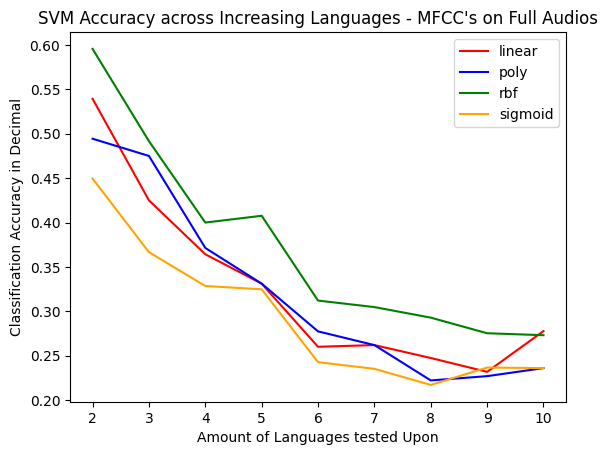

In [ ]:
#Plotting Attempt 1
plt.plot(graphic_info['linear_x'], graphic_info['linear_y'], color = 'red', label = 'linear')
plt.plot(graphic_info['poly_x'], graphic_info['poly_y'], color = 'blue', label = 'poly')
plt.plot(graphic_info['rbf_x'], graphic_info['rbf_y'], color = 'green', label = 'rbf')
plt.plot(graphic_info['sigmoid_x'], graphic_info['sigmoid_y'], color = 'orange', label = 'sigmoid')
plt.legend(loc = "upper right")
plt.ylabel('Classification Accuracy in Decimal')
plt.xlabel('Amount of Languages tested Upon')
plt.title("SVM Accuracy across Increasing Languages - MFCC's on Full Audios")
plt.show()

###**Attempt 2**

Attempt 2 differs from attempt 1 in that it calculates MFCCs on one second frames instead of entire audios. The MFCCs are still averaged (by frame) and normalized. The implementation has also greatly changed as I applied the method learned in class rather than rely on Scikit's StandardScaler, train_test_split, and LabelEncoder. The first second of audio was discarded.

This attempt performed worse than the first on the binary task between Spanish and Arabic. This time the highest accuracy was 46.93% with the sigmoid kernel, followed by 45.66% with the rbf kernel, 45.16% with the poly kernel, and finally 42.02% with the linear kernel.

Accuracy scores promptly drop with each additional langauge added.

The whole operation took 36.45 minutes to complete, 9.9 times slower than the first attempt.

In [ ]:
#Preparation - Attempt 2
def extract_features(langs, audio_list): #updated extract_features calculating MFCCs on single second frames
  samples = []
  ids = []
  labels = {}

  for i, lang in enumerate(langs):
    labels[lang] = i

  for i, path in enumerate(audio_list):
    sig, sr = librosa.load(path)
    label = regex.sub('[0-9]+', '', path.split('/')[7][:-4])

    for num in range(0, len(sig), sr):
      if num > 0: #skips the first second of audio
        samp = sig[num : num + sr]
        if len(samp) < sr:
          samples.append(np.pad(samp, (0, sr - samp.shape[0]), 'constant')) #pads the audio if shorter than one second
        else:
          samples.append(samp)
        ids.append(labels[label])

  mfccs = []
  for samp in samples:
    mfccs.append(librosa.feature.mfcc(y = samp, sr = sr, n_mfcc = 20))

  return mfccs, ids, labels

def randomize(features, ids): #function to randomize the order of the features and ids
  pairs = [(feat, id) for feat, id in zip(features, ids)]
  np.random.shuffle(pairs)
  features_new = [tup[0] for tup in pairs]
  ids_new = [tup[1] for tup in pairs]

  return features_new, ids_new

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
langs = ['spanish', 'arabic', 'mandarin', 'korean', 'french', 'russian', 'portuguese', 'dutch', 'german', 'turkish']
audio_list = [audio for lang in langs for audio in glob.glob('/content/gdrive/MyDrive/Speech Technologies/Final Project/Audios/*.mp3') if lang in audio and 'haitian creole' not in audio and 'swiss' not in audio and 'charapa' not in audio]
test_langs = langs[1:]
graphic_info = defaultdict(list)

In [ ]:
#Testing Scikit's SVM on Increasingly More Languages and Different Kernal Types - Attempt 2
start = time.time()

#Calculating the features and extracting the labels for Spanish only
audio_list_new = [path for path in audio_list if 'spanish' in path]
features, ids, labels = extract_features(langs, audio_list_new)

for i, lang in enumerate(test_langs):
  announce = [key for key in labels.keys()]
  print(f'Testing accuracy on the following languages... {announce[:i+2]}.')

  #Calculating the features and extracting the labels for each new language accent iteration
  new_paths = [path for path in audio_list if lang in path]
  new_feats, new_ids, labels = extract_features(langs, new_paths)

  #Appending the new features and labels to a growing list of accents
  for feat in new_feats:
    features.append(feat)
  for id in new_ids:
    ids.append(id)

  #Averaging and normalizing the MFCCs, transforming into an array
  mfcc_avg = np.stack([mfcc.mean(axis = 1) for mfcc in features])
  mfcc_avg = mfcc_avg - mfcc_avg.mean(axis = 0)
  mfcc_avg = mfcc_avg / mfcc_avg.std(axis = 0)

  #Transforming the labels into an array
  stacked_ids = np.stack(ids)
  num_accents = len(np.unique(stacked_ids))

  #Creating a reference to index features by label
  accent2id = []
  for i in range(num_accents):
    accent2id.append(np.where(stacked_ids == i)[0])

  #Splitting data into training and test sets for both features and ids
  train = []
  train_ids = []
  test = []
  test_ids = []

  for index in range(num_accents):
    bound = round(len(accent2id[index]) * .8)

    train.append(mfcc_avg[accent2id[index][:bound]])
    train_ids.append(stacked_ids[accent2id[index][:bound]])
    test.append(mfcc_avg[accent2id[index][bound:]])
    test_ids.append(stacked_ids[accent2id[index][bound:]])

  train = np.vstack(train)
  train_ids = np.hstack(train_ids)
  test = np.vstack(test)
  test_ids = np.hstack(test_ids)

  #Randomizing the order of the training and test sets
  train, train_ids = randomize(train, train_ids)
  test, test_ids = randomize(test, test_ids)

  for kernel in kernels:
    #Iterating over each classification algorithm, calculating its accuracy, and appending the results to a dictionary for later plotting
    classifier = SVC(kernel = kernel)
    classifier.fit(train, train_ids)

    preds = classifier.predict(test)
    accuracy = accuracy_score(test_ids, preds)
    print(f'     The {kernel} kernel has {accuracy * 100:.2f}% accuracy.')

    if kernel == 'linear':
      graphic_info['linear_x'].append(i+1)
      graphic_info['linear_y'].append(accuracy)
    elif kernel == 'poly':
      graphic_info['poly_x'].append(i+1)
      graphic_info['poly_y'].append(accuracy)
    elif kernel == 'rbf':
      graphic_info['rbf_x'].append(i+1)
      graphic_info['rbf_y'].append(accuracy)
    else:
      graphic_info['sigmoid_x'].append(i+1)
      graphic_info['sigmoid_y'].append(accuracy)

  print('\n')

end = time.time()
print(f'Operation elapsed {end - start} seconds.')

with open('graphic_info_frames.csv', 'w') as csvfile:
  writer = csv.writer(csvfile)
  for kernels, data in graphic_info.items():
    writer.writerow([kernels, data])

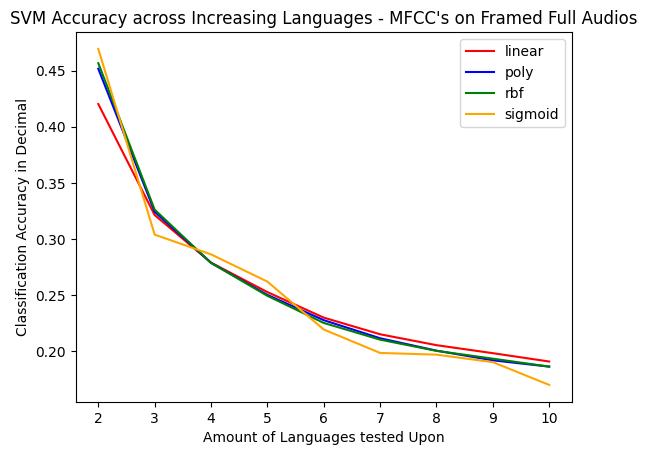

In [ ]:
#Plotting Attempt 2
plt.plot(graphic_info['linear_x'], graphic_info['linear_y'], color = 'red', label = 'linear')
plt.plot(graphic_info['poly_x'], graphic_info['poly_y'], color = 'blue', label = 'poly')
plt.plot(graphic_info['rbf_x'], graphic_info['rbf_y'], color = 'green', label = 'rbf')
plt.plot(graphic_info['sigmoid_x'], graphic_info['sigmoid_y'], color = 'orange', label = 'sigmoid')
plt.legend(loc = "upper right")
plt.ylabel('Classification Accuracy in Decimal')
plt.xlabel('Amount of Languages tested Upon')
plt.title("SVM Accuracy across Increasing Languages - MFCC's on Framed Full Audios")
plt.show()

###**Attempt 3**

Attempt 3 was an extension of attempt 2 with a few key changes. First, the MFCCs for each frame were no longer averaged across nor normalized. The normalization was left out because it brought no significant advantages or disadvantages. Second, not only single second frames were considered, but also two and three second frames. Third, only the first three and five frames were considered per audio file in two separate evaluations. And finally, instead of using all audio files, only 45 audio files per accent were considered, as this is the maximum number of audio files for the accent with the least amount of files, i.e. Turkish.

Regarding points three and four, the trimming of the data was done for the sake of consistency in comparison with attempt 4 (below). Attempt 4 applies the same method as attempt 3, but calculates embeddings instead of MFCCs. Due to the computational burden of the embeddings, the frames per audio and the audios in the dataset both had to be constrained.

*Three Frames per Sample:*

>This implementation worked better than attempt 2 with one second frames. The poly and sigmoid kernels had the highest accuracies, both at 54.17%, followed by the linear kernel with 51.39% accuracy and the rbf kernel with 50.00% accuracy.

>The two and three second frames performed equally or worse than attempt 2.

*Five Frames per Sample:*

>The five frames per sample actually hurt the performance of the classifier. The highest accuracy was only 50.93% on the sigmoid kernel, followed by 50.00% on the poly kernel, 48.15% on the linear kernel, and 46.30% on the rbf kernel, when considering single second frames.

>Likewise, the two and three second frames performed equally as bad or worse.

**More information can be found in the graphic below or in the outputs of the cells.**

The whole operation took 4.67 minutes for the 'Three Frames per Sample' run and 10.77 minutes for the 'Five Frames per Sample' run.




In [ ]:
def extract_features(langs, audio_list, multiplier): #updated extract_features function that includes a multiplier for testing on one, two, and three second frames
  samples = []
  ids = []
  labels = {}

  for i, lang in enumerate(langs):
    labels[lang] = i

  for i, path in enumerate(audio_list):
    sig, sr = librosa.load(path)
    label = regex.sub('[0-9]+', '', path.split('/')[7][:-4])

    for num in range(0, len(sig), sr * multiplier):
      if 0 < num <= (sr * 4 * multiplier):
        samp = sig[num : num + (sr * multiplier)]
        if len(samp) < (sr * multiplier):
          samples.append(np.pad(samp, (0, (sr * multiplier) - samp.shape[0]), 'constant'))
        else:
          samples.append(samp)
        ids.append(labels[label])

  mfccs = []
  for samp in samples:
    mfccs.append(librosa.feature.mfcc(y = samp, sr = sr, n_mfcc = 20))

  return mfccs, ids, labels

def randomize(features, ids):
  pairs = [(feat, id) for feat, id in zip(features, ids)]
  np.random.shuffle(pairs)
  features_new = [tup[0] for tup in pairs]
  ids_new = [tup[1] for tup in pairs]

  return features_new, ids_new

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
langs = ['spanish', 'arabic', 'mandarin', 'korean', 'french', 'russian', 'portuguese', 'dutch', 'german', 'turkish']
audio_list = [audio for lang in langs for audio in glob.glob('/content/gdrive/MyDrive/Speech Technologies/Final Project/Audios/*.mp3') if lang in audio and 'haitian creole' not in audio and 'swiss' not in audio and 'charapa' not in audio]
test_langs = langs[1:]
graphic_info = defaultdict(list)

In [ ]:
#Testing Scikit's SVM on Increasingly More Languages and Different Kernal Types - Attempt 3 - Three Frames per Audio
start = time.time()

for sec in range(1, 4): #sets the multiplier to test of one, two, and three second frames
  print(f'{sec} SECOND FRAMES...')

  #Calculating the features and extracting the labels for Spanish only
  audio_list_new = [path for path in audio_list if 'spanish' in path]
  audio_list_new = audio_list_new[:45]
  features, ids, labels = extract_features(langs, audio_list_new, sec)

  for i, lang in enumerate(test_langs):
    announce = [key for key in labels.keys()]
    print(f'     Testing accuracy on the following languages... {announce[:i+2]}.')

    #Calculating the features and extracting the labels for each new language accent iteration
    new_paths = [path for path in audio_list if lang in path]
    new_paths = new_paths[:45]
    new_feats, new_ids, labels = extract_features(langs, new_paths, sec)

    #Appending the new features and labels to a growing list of accents
    for feat in new_feats:
      features.append(feat)
    for id in new_ids:
      ids.append(id)

    #Transforming the MFCCs into an array and reshaping the array to two dimensions
    stacked_mfccs = np.stack([mfcc for mfcc in features])
    n_files, n_frames, n_coeffs = stacked_mfccs.shape
    stacked_mfccs = stacked_mfccs.reshape(n_files, n_frames * n_coeffs) #concatenates the MFCC coefficients thereby flattening across temporal frames

    #Transforming the labels into an array
    stacked_ids = np.stack(ids)
    num_accents = len(np.unique(stacked_ids))

    #Creating a reference to index features by label
    accent2id = []
    for i in range(num_accents):
      accent2id.append(np.where(stacked_ids == i)[0])

    #Splitting data into training and test sets for both features and ids
    train = []
    train_ids = []
    test = []
    test_ids = []

    for i in range(num_accents):
      bound = round(len(accent2id[i]) * .8)

      train.append(stacked_mfccs[accent2id[i][:bound]])
      train_ids.append(stacked_ids[accent2id[i][:bound]])
      test.append(stacked_mfccs[accent2id[i][bound:]])
      test_ids.append(stacked_ids[accent2id[i][bound:]])

    train = np.vstack(train)
    train_ids = np.hstack(train_ids)
    test = np.vstack(test)
    test_ids = np.hstack(test_ids)

    #Randomizing the order of the training and test sets
    train, train_ids = randomize(train, train_ids)
    test, test_ids = randomize(test, test_ids)

    for kernel in kernels:
      #Iterating over each classification algorithm, calculating its accuracy, and appending the results to a dictionary for later plotting
      classifier = SVC(kernel = kernel)
      classifier.fit(train, train_ids)

      preds = classifier.predict(test)
      accuracy = accuracy_score(test_ids, preds)
      print(f'          The {kernel} kernel has {accuracy * 100:.2f}% accuracy.')

      if kernel == 'linear':
        graphic_info[f'{sec}'].append(('linear_x', len(announce[:i+1])))
        graphic_info[f'{sec}'].append(('linear_y', accuracy))

      elif kernel == 'poly':
        graphic_info[f'{sec}'].append(('poly_x', len(announce[:i+1])))
        graphic_info[f'{sec}'].append(('poly_y', accuracy))

      elif kernel == 'rbf':
        graphic_info[f'{sec}'].append(('rbf_x', len(announce[:i+1])))
        graphic_info[f'{sec}'].append(('rbf_y', accuracy))

      else:
        graphic_info[f'{sec}'].append(('sigmoid_x', len(announce[:i+1])))
        graphic_info[f'{sec}'].append(('sigmoid_y', accuracy))

    print('\n')

  mid = time.time()
  if sec == 1:
    print(f'     Operation on {sec} second frames elasped {mid - start}.\n')
  else:
    print(f'     Operation on {sec} second frames elasped {mid - reference}.\n')
  reference = time.time()

end = time.time()
print(f'Operation elapsed {end - start} seconds.')

with open('graphic_info_frames_1-3SECONDS.csv', 'w') as csvfile:
  writer = csv.writer(csvfile)
  for kernels, data in graphic_info.items():
    writer.writerow([kernels, data])

In [ ]:
#Reloads and Transforms the CSV Storage Files for Plotting
mfcc_info_3 = {}
with open('graphic_info_frames_1-3SECONDS.csv') as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    mfcc_info_3[row[0]] = row[1]

for key, value in mfcc_info_3.items():
  mfcc_info_3[key] = ast.literal_eval(value)

mfcc_info_5 = {}
with open('graphic_info_frames_1-5SECONDS.csv') as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    mfcc_info_5[row[0]] = row[1]

for key, value in mfcc_info_5.items():
  mfcc_info_5[key] = ast.literal_eval(value)

mfcc_info_3_1, mfcc_info_3_2, mfcc_info_3_3 = dict_transformer(mfcc_info_3)
mfcc_info_5_1, mfcc_info_5_2, mfcc_info_5_3 = dict_transformer(mfcc_info_5)

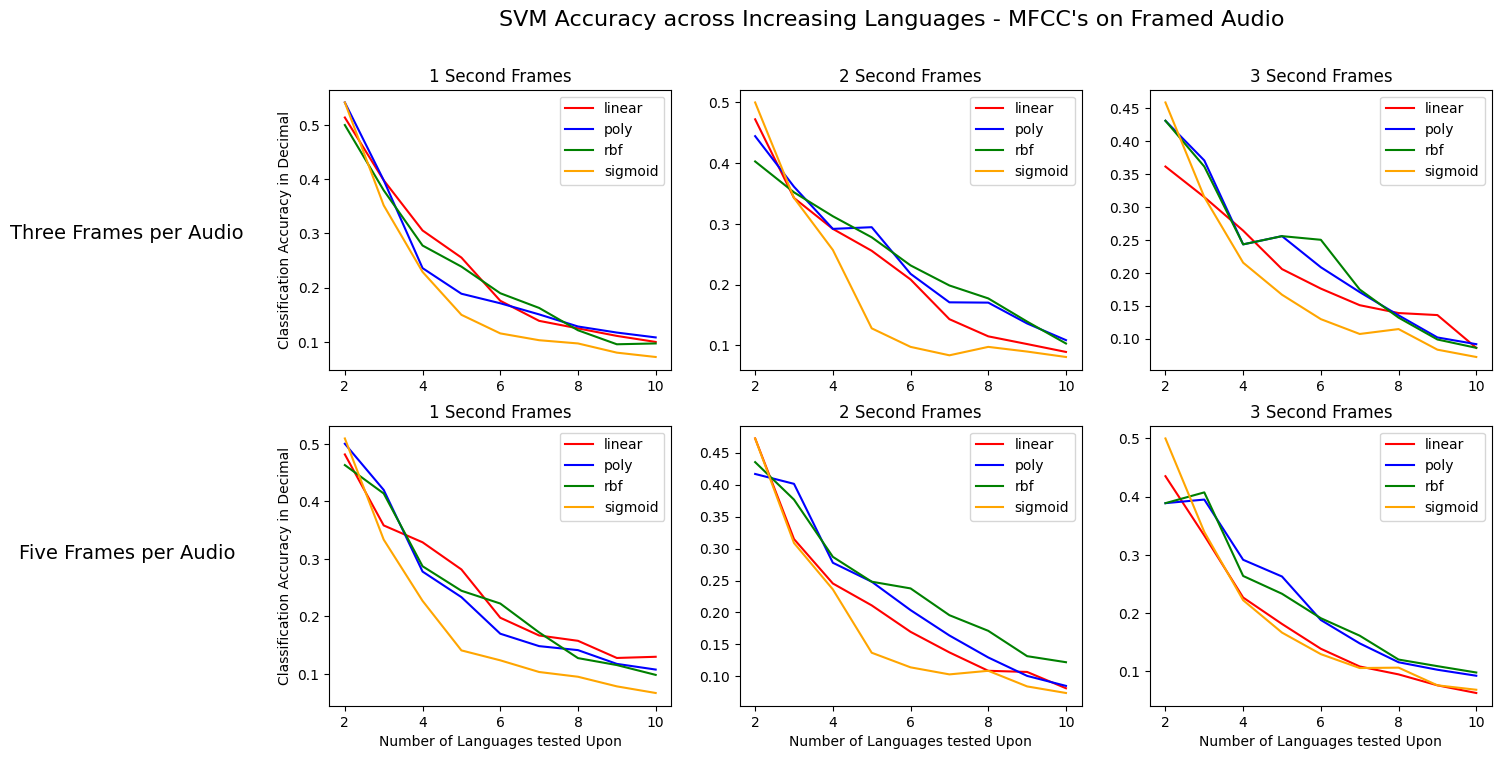

In [ ]:
#Plotting Attempt 3
plt.figure(figsize = [15, 8])

plt.subplot(2,3,1)
plt.plot(mfcc_info_3_1['linear_x'], mfcc_info_3_1['linear_y'], color = 'red', label = 'linear')
plt.plot(mfcc_info_3_1['poly_x'], mfcc_info_3_1['poly_y'], color = 'blue', label = 'poly')
plt.plot(mfcc_info_3_1['rbf_x'], mfcc_info_3_1['rbf_y'], color = 'green', label = 'rbf')
plt.plot(mfcc_info_3_1['sigmoid_x'], mfcc_info_3_1['sigmoid_y'], color = 'orange', label = 'sigmoid')
plt.legend(loc = "upper right")
plt.ylabel('Classification Accuracy in Decimal')
plt.title("1 Second Frames")

plt.subplot(2,3,2)
plt.plot(mfcc_info_3_2['linear_x'], mfcc_info_3_2['linear_y'], color = 'red', label = 'linear')
plt.plot(mfcc_info_3_2['poly_x'], mfcc_info_3_2['poly_y'], color = 'blue', label = 'poly')
plt.plot(mfcc_info_3_2['rbf_x'], mfcc_info_3_2['rbf_y'], color = 'green', label = 'rbf')
plt.plot(mfcc_info_3_2['sigmoid_x'], mfcc_info_3_2['sigmoid_y'], color = 'orange', label = 'sigmoid')
plt.legend(loc = "upper right")
plt.title("2 Second Frames")

plt.subplot(2,3,3)
plt.plot(mfcc_info_3_3['linear_x'], mfcc_info_3_3['linear_y'], color = 'red', label = 'linear')
plt.plot(mfcc_info_3_3['poly_x'], mfcc_info_3_3['poly_y'], color = 'blue', label = 'poly')
plt.plot(mfcc_info_3_3['rbf_x'], mfcc_info_3_3['rbf_y'], color = 'green', label = 'rbf')
plt.plot(mfcc_info_3_3['sigmoid_x'], mfcc_info_3_3['sigmoid_y'], color = 'orange', label = 'sigmoid')
plt.legend(loc = "upper right")
plt.title("3 Second Frames")

plt.subplot(2,3,4)
plt.plot(mfcc_info_5_1['linear_x'], mfcc_info_5_1['linear_y'], color = 'red', label = 'linear')
plt.plot(mfcc_info_5_1['poly_x'], mfcc_info_5_1['poly_y'], color = 'blue', label = 'poly')
plt.plot(mfcc_info_5_1['rbf_x'], mfcc_info_5_1['rbf_y'], color = 'green', label = 'rbf')
plt.plot(mfcc_info_5_1['sigmoid_x'], mfcc_info_5_1['sigmoid_y'], color = 'orange', label = 'sigmoid')
plt.legend(loc = "upper right")
plt.ylabel('Classification Accuracy in Decimal')
plt.xlabel('Number of Languages tested Upon')
plt.title("1 Second Frames")

plt.subplot(2,3,5)
plt.plot(mfcc_info_5_2['linear_x'], mfcc_info_5_2['linear_y'], color = 'red', label = 'linear')
plt.plot(mfcc_info_5_2['poly_x'], mfcc_info_5_2['poly_y'], color = 'blue', label = 'poly')
plt.plot(mfcc_info_5_2['rbf_x'], mfcc_info_5_2['rbf_y'], color = 'green', label = 'rbf')
plt.plot(mfcc_info_5_2['sigmoid_x'], mfcc_info_5_2['sigmoid_y'], color = 'orange', label = 'sigmoid')
plt.legend(loc = "upper right")
plt.xlabel('Number of Languages tested Upon')
plt.title("2 Second Frames")

plt.subplot(2,3,6)
plt.plot(mfcc_info_5_3['linear_x'], mfcc_info_5_3['linear_y'], color = 'red', label = 'linear')
plt.plot(mfcc_info_5_3['poly_x'], mfcc_info_5_3['poly_y'], color = 'blue', label = 'poly')
plt.plot(mfcc_info_5_3['rbf_x'], mfcc_info_5_3['rbf_y'], color = 'green', label = 'rbf')
plt.plot(mfcc_info_5_3['sigmoid_x'], mfcc_info_5_3['sigmoid_y'], color = 'orange', label = 'sigmoid')
plt.legend(loc = "upper right")
plt.xlabel('Number of Languages tested Upon')
plt.title("3 Second Frames")

plt.text(-0.01, 0.7, 'Three Frames per Audio', va='center', ha='center', rotation='horizontal', fontsize=14, transform=plt.gcf().transFigure)
plt.text(-0.01, 0.3, 'Five Frames per Audio', va='center', ha='center', rotation='horizontal', fontsize=14, transform=plt.gcf().transFigure)

plt.suptitle("SVM Accuracy across Increasing Languages - MFCC's on Framed Audio", fontsize = 16)
plt.show()

###**Attempt 4**

Attempt 4 is identical in implementation to attempt 3, for comparison purposes, with the key difference that features were calculated using embeddings instead of MFCCs.

In both of the following test runs, the embeddings outperformed the MFCCs by about 10% accuracy on average.

*Three Frames per Sample:*
> The best performer for the binary task actually came from the two second frames using the sigmoid kernel at 65.28% accuracy. This was followed by the rbf kernel with 63.89% accuracy, the poly kernel with 61.11% accuracy, and the linear kernel with 58.33% accuracy.

*Five Frames per Sample:*

> Similar to the 'Three Frames per Sample' run, the best accuracies for the binary task came from the three second, rather than one second frames. The highest accuracy appeared in the linear kernel at 66.67%. This was followed by 62.96% accuracy in the rbf kernel and 62.04% accuracy for both the poly and sigmoid kernels.

**More information can be found in the graphic below or in the outputs of the cells.**

The whole operation took 44.77 minutes for the 'Three Frames per Sample' run, 9.59 times slower than the equivocal test on MFCCs, and 60.39 minutes for the 'Five Frames per Sample' run, 5.6 times slower than the equivocal test on MFCCs.




In [ ]:
def extract_features(langs, audio_list, multiplier):
  samples = []
  ids = []
  embeds = []
  labels = {}

  for i, lang in enumerate(langs):
    labels[lang] = i

  for i, path in enumerate(audio_list):
    sig, sr = librosa.load(path)
    label = regex.sub('[0-9]+', '', path.split('/')[7][:-4])

    for num in range(0, len(sig), sr * multiplier):
      if 0 < num <= (sr * 4 * multiplier):
        samp = sig[num : num + (sr * multiplier)]
        if len(samp) < (sr * multiplier):
          samples.append(np.pad(samp, (0, (sr * multiplier) - samp.shape[0]), 'constant'))
        else:
          samples.append(samp)
        ids.append(labels[label])

  for sample in samples:
    embeds.append(FeatureExtractor.encode_batch(torch.tensor(sample)).squeeze())

  return embeds, ids, labels

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
langs = ['spanish', 'arabic', 'mandarin', 'korean', 'french', 'russian', 'portuguese', 'dutch', 'german', 'turkish']
audio_list = [audio for lang in langs for audio in glob.glob('/content/gdrive/MyDrive/Speech Technologies/Final Project/Audios/*.mp3') if lang in audio and 'haitian creole' not in audio and 'swiss' not in audio and 'charapa' not in audio]
test_langs = langs[1:]
graphic_info = defaultdict(list)

In [ ]:
#Testing Scikit's SVM on Increasingly More Languages and Different Kernal Types - Attempt 4 - Three Frames per Audio
start = time.time()

for sec in range(1, 4): #sets the multiplier to test of one, two, and three second frames
  print(f'{sec} SECOND FRAMES...')

  #Calculating the features and extracting the labels for Spanish only
  audio_list_new = [path for path in audio_list if 'spanish' in path]
  audio_list_new = audio_list_new[:45]
  features, ids, labels = extract_features(langs, audio_list_new, sec)

  for i, lang in enumerate(test_langs):
    announce = [key for key in labels.keys()]
    print(f'     Testing accuracy on the following languages... {announce[:i+2]}.')

    #Calculating the features and extracting the labels for each new language accent iteration
    new_paths = [path for path in audio_list if lang in path]
    new_paths = new_paths[:45]
    new_feats, new_ids, labels = extract_features(langs, new_paths, sec)

    #Appending the new features and labels to a growing list of accents
    for feat in new_feats:
      features.append(feat)
    for id in new_ids:
      ids.append(id)

    #Transforming the labels and features into array
    stacked_embeds = np.stack(features)
    stacked_ids = np.stack(ids)
    num_accents = len(np.unique(stacked_ids))

    #Creating a reference to index features by label
    accent2id = []
    for i in range(num_accents):
      accent2id.append(np.where(stacked_ids == i)[0])

    #Splitting data into training and test sets for both features and ids
    train = []
    train_ids = []
    test = []
    test_ids = []

    for i in range(num_accents):
      bound = round(len(accent2id[i]) * .8)

      train.append(stacked_embeds[accent2id[i][:bound]])
      train_ids.append(stacked_ids[accent2id[i][:bound]])
      test.append(stacked_embeds[accent2id[i][bound:]])
      test_ids.append(stacked_ids[accent2id[i][bound:]])

    train = np.vstack(train)
    train_ids = np.hstack(train_ids)
    test = np.vstack(test)
    test_ids = np.hstack(test_ids)

    #Randomizing the order of the training and test sets
    train, train_ids = randomize(train, train_ids)
    test, test_ids = randomize(test, test_ids)

    for kernel in kernels:
      #Iterating over each classification algorithm, calculating its accuracy, and appending the results to a dictionary for later plotting
      classifier = SVC(kernel = kernel)
      classifier.fit(train, train_ids)

      preds = classifier.predict(test)
      accuracy = accuracy_score(test_ids, preds)
      print(f'          The {kernel} kernel has {accuracy * 100:.2f}% accuracy.')

      if kernel == 'linear':
        graphic_info[f'{sec}'].append(('linear_x', len(announce[:i+1])))
        graphic_info[f'{sec}'].append(('linear_y', accuracy))

      elif kernel == 'poly':
        graphic_info[f'{sec}'].append(('poly_x', len(announce[:i+1])))
        graphic_info[f'{sec}'].append(('poly_y', accuracy))

      elif kernel == 'rbf':
        graphic_info[f'{sec}'].append(('rbf_x', len(announce[:i+1])))
        graphic_info[f'{sec}'].append(('rbf_y', accuracy))

      else:
        graphic_info[f'{sec}'].append(('sigmoid_x', len(announce[:i+1])))
        graphic_info[f'{sec}'].append(('sigmoid_y', accuracy))

    print('\n')

  mid = time.time()
  if sec == 1:
    print(f'     Operation on {sec} second frames elasped {mid - start}.\n')
  else:
    print(f'     Operation on {sec} second frames elasped {mid - reference}.\n')
  reference = time.time()

end = time.time()
print(f'Operation elapsed {end - start} seconds.')

with open('graphic_info_frames_1-3SECONDS_embed.csv', 'w') as csvfile:
  writer = csv.writer(csvfile)
  for kernels, data in graphic_info.items():
    writer.writerow([kernels, data])

In [ ]:
#Reloads and Transforms the CSV Storage Files for Plotting
embeds_info_3 = {}
with open('graphic_info_frames_1-3SECONDS_embed.csv') as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    embeds_info_3[row[0]] = row[1]

for key, value in embeds_info_3.items():
  embeds_info_3[key] = ast.literal_eval(value)

embeds_info_5 = {}
with open('graphic_info_frames_1-5SECONDS_embed.csv') as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    embeds_info_5[row[0]] = row[1]

for key, value in embeds_info_5.items():
  embeds_info_5[key] = ast.literal_eval(value)

embeds_info_3_1, embeds_info_3_2, embeds_info_3_3 = dict_transformer(embeds_info_3)
embeds_info_5_1, embeds_info_5_2, embeds_info_5_3 = dict_transformer(embeds_info_5)

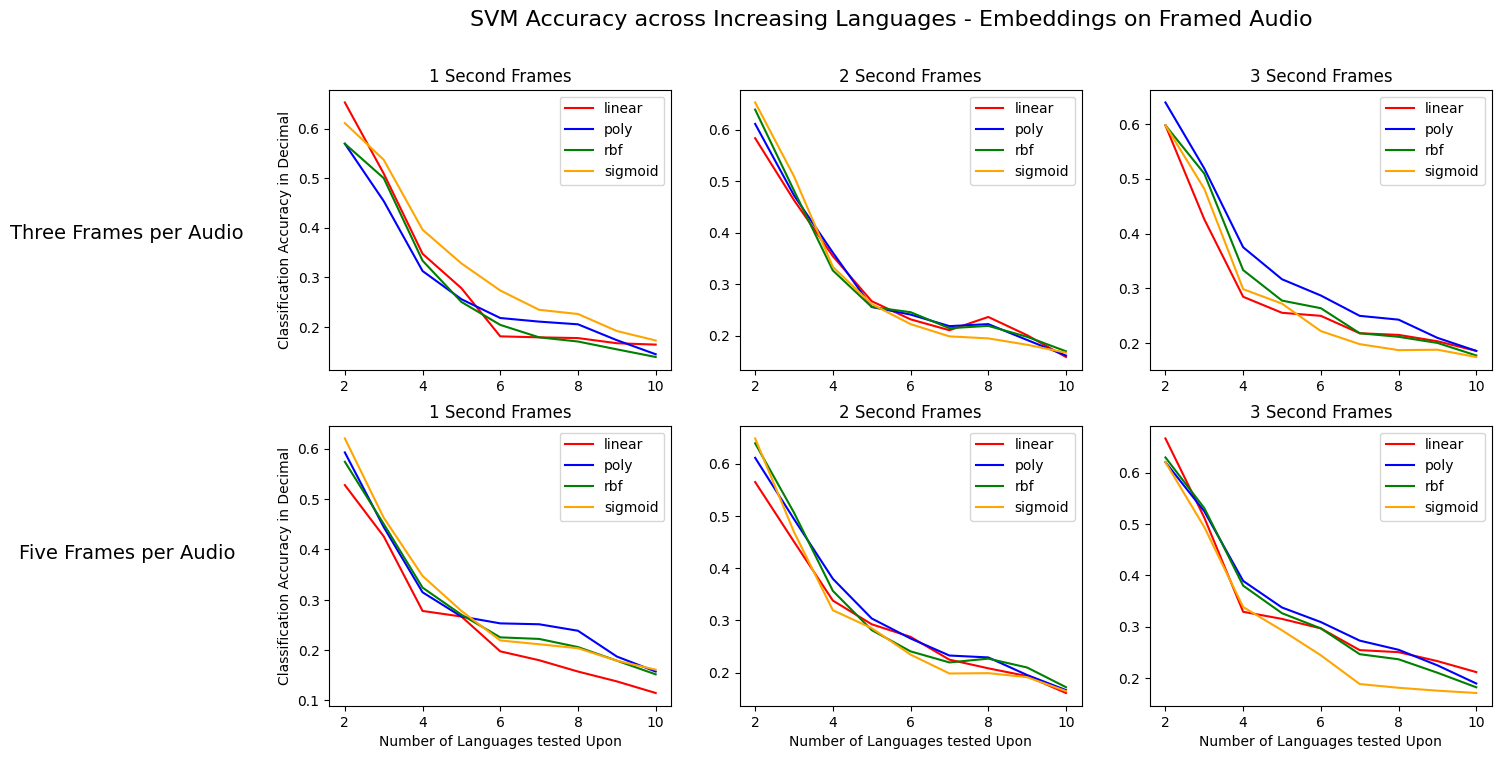

In [ ]:
#Plotting Attempt 4
plt.figure(figsize = [15, 8])

plt.subplot(2,3,1)
plt.plot(embeds_info_3_1['linear_x'], embeds_info_3_1['linear_y'], color = 'red', label = 'linear')
plt.plot(embeds_info_3_1['poly_x'], embeds_info_3_1['poly_y'], color = 'blue', label = 'poly')
plt.plot(embeds_info_3_1['rbf_x'], embeds_info_3_1['rbf_y'], color = 'green', label = 'rbf')
plt.plot(embeds_info_3_1['sigmoid_x'], embeds_info_3_1['sigmoid_y'], color = 'orange', label = 'sigmoid')
plt.legend(loc = "upper right")
plt.ylabel('Classification Accuracy in Decimal')
plt.title("1 Second Frames")

plt.subplot(2,3,2)
plt.plot(embeds_info_3_2['linear_x'], embeds_info_3_2['linear_y'], color = 'red', label = 'linear')
plt.plot(embeds_info_3_2['poly_x'], embeds_info_3_2['poly_y'], color = 'blue', label = 'poly')
plt.plot(embeds_info_3_2['rbf_x'], embeds_info_3_2['rbf_y'], color = 'green', label = 'rbf')
plt.plot(embeds_info_3_2['sigmoid_x'], embeds_info_3_2['sigmoid_y'], color = 'orange', label = 'sigmoid')
plt.legend(loc = "upper right")
plt.title("2 Second Frames")

plt.subplot(2,3,3)
plt.plot(embeds_info_3_3['linear_x'], embeds_info_3_3['linear_y'], color = 'red', label = 'linear')
plt.plot(embeds_info_3_3['poly_x'], embeds_info_3_3['poly_y'], color = 'blue', label = 'poly')
plt.plot(embeds_info_3_3['rbf_x'], embeds_info_3_3['rbf_y'], color = 'green', label = 'rbf')
plt.plot(embeds_info_3_3['sigmoid_x'], embeds_info_3_3['sigmoid_y'], color = 'orange', label = 'sigmoid')
plt.legend(loc = "upper right")
plt.title("3 Second Frames")

plt.subplot(2,3,4)
plt.plot(embeds_info_5_1['linear_x'], embeds_info_5_1['linear_y'], color = 'red', label = 'linear')
plt.plot(embeds_info_5_1['poly_x'], embeds_info_5_1['poly_y'], color = 'blue', label = 'poly')
plt.plot(embeds_info_5_1['rbf_x'], embeds_info_5_1['rbf_y'], color = 'green', label = 'rbf')
plt.plot(embeds_info_5_1['sigmoid_x'], embeds_info_5_1['sigmoid_y'], color = 'orange', label = 'sigmoid')
plt.legend(loc = "upper right")
plt.ylabel('Classification Accuracy in Decimal')
plt.xlabel('Number of Languages tested Upon')
plt.title("1 Second Frames")

plt.subplot(2,3,5)
plt.plot(embeds_info_5_2['linear_x'], embeds_info_5_2['linear_y'], color = 'red', label = 'linear')
plt.plot(embeds_info_5_2['poly_x'], embeds_info_5_2['poly_y'], color = 'blue', label = 'poly')
plt.plot(embeds_info_5_2['rbf_x'], embeds_info_5_2['rbf_y'], color = 'green', label = 'rbf')
plt.plot(embeds_info_5_2['sigmoid_x'], embeds_info_5_2['sigmoid_y'], color = 'orange', label = 'sigmoid')
plt.legend(loc = "upper right")
plt.xlabel('Number of Languages tested Upon')
plt.title("2 Second Frames")

plt.subplot(2,3,6)
plt.plot(embeds_info_5_3['linear_x'], embeds_info_5_3['linear_y'], color = 'red', label = 'linear')
plt.plot(embeds_info_5_3['poly_x'], embeds_info_5_3['poly_y'], color = 'blue', label = 'poly')
plt.plot(embeds_info_5_3['rbf_x'], embeds_info_5_3['rbf_y'], color = 'green', label = 'rbf')
plt.plot(embeds_info_5_3['sigmoid_x'], embeds_info_5_3['sigmoid_y'], color = 'orange', label = 'sigmoid')
plt.legend(loc = "upper right")
plt.xlabel('Number of Languages tested Upon')
plt.title("3 Second Frames")

plt.text(-0.01, 0.7, 'Three Frames per Audio', va='center', ha='center', rotation='horizontal', fontsize=14, transform=plt.gcf().transFigure)
plt.text(-0.01, 0.3, 'Five Frames per Audio', va='center', ha='center', rotation='horizontal', fontsize=14, transform=plt.gcf().transFigure)

plt.suptitle("SVM Accuracy across Increasing Languages - Embeddings on Framed Audio", fontsize = 16)
plt.show()